# CTG DRE
1st read in the dfa 
location: https://archive.ics.uci.edu/ml/datasets/cardiotocography

In [1]:
import sys
import pandas as pd
import numpy as np
import torch
from torch import distributions
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy import optimize
import pickle
import warnings
from copy import deepcopy
# setting path
sys.path.append('..')

from functions.np_classifier_torch import cutoff_bin, power_alpha_calc  # noqa: E402
from functions.estimators_torch import kliep_miss_wrap, kliep_multi_dim_sep_wrap, kliep_multi_dim_naive_sep_wrap
from functions.estimators_torch import kliep_multi_dim_imp_wrap, kliep_multi_dim_sep_imp_wrap  # noqa: E402
from functions.objective_funcs_torch import get_dat_vals_impute, get_dat_vals_multidim
from functions.pipeline_funcs import missing_pipeline, full_pipeline, func_adj, get_ci, progress, create_standard_miss_func

unif=distributions.Uniform(0,1)
plt.rcParams["figure.facecolor"] = "White"
plt.rcParams["savefig.facecolor"] = "White"
plt.rc('font',**{'family':'sans-serif', 'size': 14})
#If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)

page_width=9
width_height_ratio=3/4

In [2]:
# Read in data
df = pd.read_excel("../real_world_data/CTG.xls",sheet_name="Raw Data")
#Remove unnecssary columns
df_fin = df.iloc[1: , np.arange(6,14).tolist()+[24,26,39]]

null_df = df_fin[df_fin["NSP"]!=1].drop("NSP",axis=1)
alt_df = df_fin[df_fin["NSP"]==1].drop("NSP",axis=1)

df_fin_nodrop=df_fin.drop("NSP",axis=1)

# Get normalisation terms from training tensor
std = np.nanstd(df_fin_nodrop.to_numpy(), axis=0)
m = np.nanmean(df_fin_nodrop.to_numpy(), axis=0)

# Single Examples
## No missing data

In [3]:
lr = 0.7**(np.floor((np.arange(1000))/100)+1)
temp_nomiss_norm = full_pipeline(
        null_df, alt_df, None, n_altte=100, n_nulltr=237, 
        dr_proc = kliep_miss_wrap, dat_val_fun = get_dat_vals_impute,
        maxiter=1000, est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        split_seed=123
        )
temp_nomiss_norm["power_res"]

[[tensor(0.7900), tensor(0.0675)]]

## Corrupted Data, known $\varphi$

Now try corrupting the data. We will corrupt them in the worst directions possible 


In [4]:
signs=np.sign(temp_nomiss_norm["dr"]["par"])
missing_funcs = [create_standard_miss_func(m[j],std[j],-signs[j]) for j in range(10)]

Plot these to see what they look like

(10,)


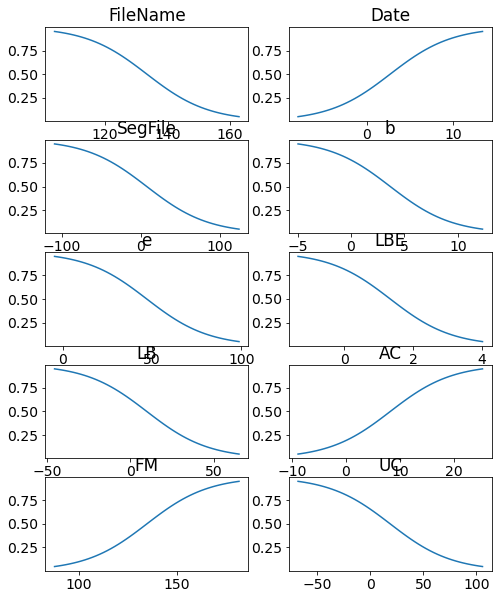

In [5]:
print(m.shape)
# adjust true function to be on same scale as normalised data

fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(8,10))
for j in range(10):
    x=torch.linspace(m[j]-3*std[j],m[j]+3*std[j],50)
    y=missing_funcs[j](x)
    ax[j//2,j%2].plot(x,y)
    ax[j//2,j%2].set(title=df.columns[j])

Now try the approach knowing these missing funcs with the same data split and random missing data

In [6]:
# Test true method
temp_true = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        est_miss=False, lr=lr, alpha=0.1, delta=0.05, maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_true["power_res"]

[[tensor(0.6900), tensor(0.0675)]]

We lose a fair amount of power however we now need to see how this compares to the naive approach.

In [7]:
    # Test naive method
temp_naive = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_naive_sep_wrap,
        est_miss=False, lr=lr, alpha=0.1, delta=0.05, maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_naive["power_res"]

[[tensor(0.5000), tensor(0.0675)]]

This performs far worse. Out of curiosity see if the reduction in power for our method comes from ultilising the naive assumption more heavily.

In [8]:
temp_nomiss_nb = full_pipeline(
    null_df, alt_df, None, n_altte=100, n_nulltr=237,
    est_miss=False, lr=lr, alpha=0.1, delta=0.05, maxiter=1000,
    split_seed=123)
temp_nomiss_nb["power_res"]


[[tensor(0.7100), tensor(0.0675)]]

## Iterative Imputation
Now try MICE approach

In [9]:
mice_args = {"sample_posterior": False, "n_nearest_features": 9}  
    
# Test mice method
temp_mice = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_imp_wrap, impute="MICE", mice_args=mice_args,
        est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_mice["power_res"]

[[tensor(0.7600), tensor(0.0675)]]

This performs surprisingly well. Now, separate each dimension

In [17]:
mice_args = {"sample_posterior": False, "n_nearest_features": 9}  
    
# Test mice method
temp_mice_naive = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_sep_imp_wrap, impute="MICE", mice_args=mice_args,
        est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_mice_naive["power_res"]

[[tensor(0.5800), tensor(0.0675)]]

We then get our worse performance back again which is interesting. This suggests that marginally our samples are wrong but jointly this is not the case?

## Uniform Imputation
Now try uniform imputation along each

In [10]:
temp_marg = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_imp_wrap, impute="Uniform",
        est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_marg["power_res"]

[[tensor(0.7400), tensor(0.0675)]]

In [11]:
temp_marg_naive = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_sep_imp_wrap, impute="Uniform",
        est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_marg_naive["power_res"]

[[tensor(0.5100), tensor(0.0675)]]

## Weighted Imputation

In [12]:
temp_marg_weighted = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_imp_wrap, impute="Weighted",
        est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_marg_weighted["power_res"]

[[tensor(0.7800), tensor(0.0675)]]

In [13]:
temp_marg_weighted_naive = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_sep_imp_wrap, impute="Weighted",
        est_miss=False, lr=lr, alpha=0.1, delta=0.05,
        maxiter=1000,
        split_seed=123, miss_seed=1234)
temp_marg_weighted_naive["power_res"]

[[tensor(0.6900), tensor(0.0675)]]

That seems to be the case.

## Learning $\varphi$
Now try and learn the missingness function. We adapt the ideas of King, Zeng 2001 to do this.

In [14]:
    # Test our method 
temp_our = full_pipeline(
    null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
    est_miss=True, lr=lr,alpha=0.1, delta=0.05, nlearn=25, maxiter=1000,
    split_seed=123,miss_seed=1234,learn_seed=12345)
temp_our["power_res"]

[[tensor(0.7000), tensor(0.0675)]]

Performs identically to method with known missingness funcs!. Out of curiosity plot these missingness funcs against the true ones to compare accuracy.

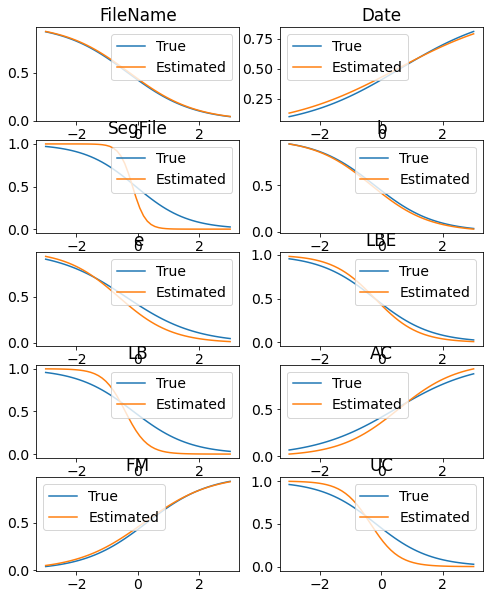

In [23]:
adj_miss_funcs = [func_adj(
    temp_our["norm"]["mean"][j], temp_our["norm"]["std"][j], missing_funcs[j]
    ) for j in range(len(missing_funcs))]
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
for j in range(10):
    x = torch.linspace(-3, 3, 50)
    y = adj_miss_funcs[j](x)
    y_est = temp_our["est_miss_funcs"][j](x)
    ax[j//2, j % 2].plot(x, y, label="True")
    ax[j//2, j % 2].plot(x, y_est, label="Estimated")
    ax[j//2, j % 2].set(title=df.columns[j])
    ax[j//2, j % 2].legend()


Quite good approximation with only 25 points.

# Repeated Fixed Scenarios
## Random direction missingness
We now try the same procedure but choosing direction of corruption for each feature randomly.
We will do this 10 times

In [14]:
best_meth = []
naive_meth = []
for i in range(1000):
        # ### Chossing missing functions ### #
    signs = torch.multinomial(torch.zeros((2))+1, num_samples=10,
                              replacement=True)
    missing_funcs = [create_standard_miss_func(m[j],std[j],-signs[j]) for j in range(10)]
# Test new pipeline
    temp_our = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        est_miss=True, lr=lr,alpha=0.1, delta=0.05, nlearn=25, maxiter=1000,
        split_seed=123,miss_seed=1234,learn_seed=12345)
    best_meth.append(temp_our["power_res"])

    # Test new pipeline.
    # Test naive method
    temp_naive = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_naive_sep_wrap,
        est_miss=False, lr=lr, alpha=0.1, delta=0.05, maxiter=1000,
        split_seed=123, miss_seed=1234)
    naive_meth.append(temp_naive["power_res"])

results = {"Learning Missingness Func": best_meth, "Naive": naive_meth}

with open('../results/real_world_results/CTG_missrand_1000sim_ourmeth.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Give results

In [15]:
with open('../results/real_world_results/CTG_missrand_1000sim_ourmeth.pkl', 'rb') as handle:
    results = pickle.load(handle)

for key in results:
    print("For "+key+" Method")
    get_ci(torch.tensor(results[key])[:,0])

For Learning Missingness Func Method
Our Estimated Expected Power is: 0.708
With ci(0.707, 0.708)
For Naive Method
Our Estimated Expected Power is: 0.689
With ci(0.685, 0.692)


# Varying $\alpha$
Now try all the different approaches each time with completely new data split and for various $\alpha$.

In [27]:
warnings.filterwarnings("ignore")
new_meth = []
true_meth = []
best_meth = []
naive_meth = []
nomiss_nb_meth = []
nomiss_norm_meth = []
mice_meth = []
new_seed = 12344
reg = 0
alphas = [0.3,0.25,0.2,0.15,0.1,0.05]
deltas = [0.05]*len(alphas)
mice_args = {"sample_posterior": False, "n_nearest_features": 9}  
nsim=1000
for i in range(nsim):
    torch.manual_seed(new_seed)
    # ### Seed Setting ### #
    split_seed = int(1e9*unif.sample([1])[0])
    miss_seed = int(1e9*unif.sample([1])[0])
    learn_seed = int(1e9*unif.sample([1])[0])
    new_seed = int(1e9*unif.sample([1])[0])

    # ### Chossing missing functions ### #
    signs = torch.tensor([-1., 1.])
    signs = signs[torch.multinomial(torch.zeros((2))+1, num_samples=10,
                                    replacement=True)]
    missing_funcs = [create_standard_miss_func(
        m[j], std[j], -signs[j]) for j in range(10)]

    # Test our method
    temp_our = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        est_miss=True, lr=lr, alpha=alphas, delta=deltas, nlearn=10, maxiter=1000,
        reg=reg,
        split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
    # Re-do with smaller LR if errors
    if any(torch.isnan(temp_our["dr"]["par"]).reshape(-1)):
        print(f"Fail on run {i}")
        print(f"Seeds are: Split - {split_seed}, Miss - {miss_seed}, Learn - {learn_seed}")
        print(f"Signs are {signs}")
        temp_our = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
            est_miss=True, lr=0.1*lr, alpha=alphas, delta=deltas, nlearn=10, maxiter=1000,
            reg=reg,
            split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
        if any(torch.isnan(temp_our["dr"]["par"]).reshape(-1)):
            print(f"Still not Working on run {i}")
    best_meth.append(temp_our["power_res"])

    # Test true method
    temp_true = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        est_miss=False, lr=lr, alpha=alphas, delta=deltas, maxiter=1000,
        reg=reg,
        split_seed=split_seed, miss_seed=miss_seed)
    true_meth.append(temp_true["power_res"])

    # Test naive method
    temp_naive = full_pipeline(
        null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_naive_sep_wrap,
        est_miss=False, lr=lr, alpha=alphas, delta=deltas, maxiter=1000,
        reg=reg,
        split_seed=split_seed, miss_seed=miss_seed)
    naive_meth.append(temp_naive["power_res"])

    temp_nomiss_nb = full_pipeline(
        null_df, alt_df, None, n_altte=100, n_nulltr=237,
        est_miss=False, lr=lr, alpha=alphas, delta=deltas, maxiter=1000,
        reg=reg,
        split_seed=split_seed)
    nomiss_nb_meth.append(temp_nomiss_nb["power_res"])

    temp_nomiss_norm = full_pipeline(
        null_df, alt_df, None, n_altte=100, n_nulltr=237,
        dr_proc=kliep_miss_wrap, dat_val_fun=get_dat_vals_impute,
        est_miss=False, lr=lr, alpha=alphas, delta=deltas, maxiter=1000,
        reg=reg,
        split_seed=split_seed)
    nomiss_norm_meth.append(temp_nomiss_norm["power_res"])

    temp_mice = full_pipeline(
        null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_sep_imp_wrap, impute="MICE", opt_type="Scalar",
        mice_args=mice_args, est_miss=False, lr=lr, alpha=alphas,
        delta=deltas, maxiter=1000,
        split_seed=split_seed, miss_seed=miss_seed)
    mice_meth.append(temp_mice["power_res"])

    # Print progress
    progress(int(100*(i+1)/nsim))

results = {
    "Learning Missingness Func": best_meth,
    "Naive": naive_meth, "Known Missingness Func": true_meth,
    "No Missing NB": nomiss_nb_meth, "No Missing Normal": nomiss_norm_meth,
    "MICE": mice_meth
}

data = (results,{"alphas": alphas, "deltas": deltas})
with open('../results/real_world_results/CTG_fullrand_'+str(nsim)+'sim_allmeth_noreg_varyalpha.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


[########                                ]22%Fail on run 221
Seeds are: Split - 909081728, Miss - 611009280, Learn - 481309344
Signs are tensor([-1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.])
[################                        ]40%Fail on run 408
Seeds are: Split - 801440256, Miss - 667935808, Learn - 421786080
Signs are tensor([ 1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.])
[##########################              ]66%Fail on run 665
Seeds are: Split - 835022400, Miss - 160659008, Learn - 437058912
Signs are tensor([ 1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.])
[###########################             ]68%Fail on run 683
Seeds are: Split - 452783296, Miss - 392387136, Learn - 926203456
Signs are tensor([-1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.])
[####################################### ]98%Fail on run 988
Seeds are: Split - 19364596, Miss - 473424960, Learn - 765411648
Signs are tensor([-1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.])
[####################

Give results

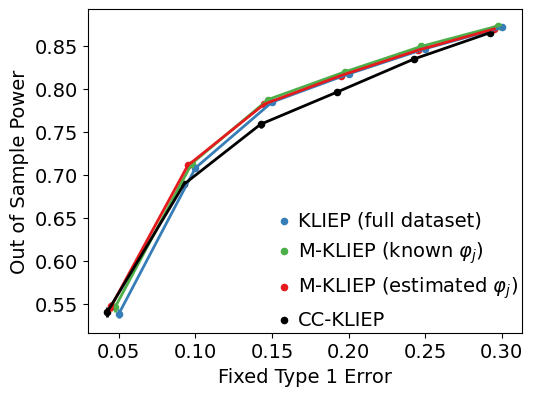

In [2]:
with open('../results/real_world_results/CTG_fullrand_1000sim_allmeth_noreg_varyalpha.pkl', 'rb') as handle:
    results, params = pickle.load(handle)

names = {
    "No Missing NB": "KLIEP (full dataset)",
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$)",
    "Naive": "CC-KLIEP"
}

cs = [u'#377eb8', u'#4daf4a', u'#e41a1c', u'#000000',u"#984ea3"]
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(names):
    x = np.array(params["alphas"])
    all_cis = get_ci(torch.tensor(results[key])[:, :, 0],
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff = x[1]-x[0]

    x_jit = x+diff*0.05*i

    ax.scatter(x_jit, y, label=names[key], s=20, c=cs[i])
    ax.errorbar(x_jit, y, error, c=cs[i],linewidth=2)

ax.set(xlabel="Fixed Type 1 Error", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)


plt.savefig("../plots/np_RWE_CTG_varyalpha.pdf",
            bbox_inches="tight", dpi=300)


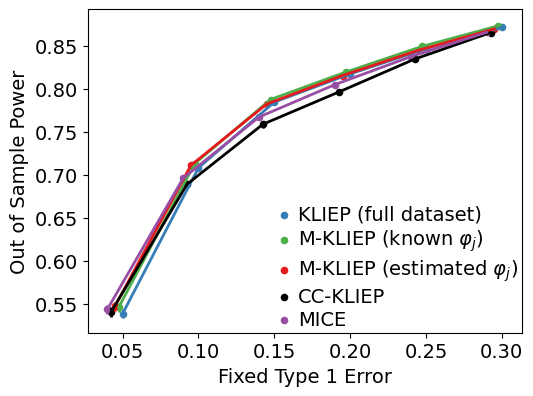

In [3]:
with open('../results/real_world_results/CTG_fullrand_1000sim_allmeth_noreg_varyalpha.pkl', 'rb') as handle:
    results, params = pickle.load(handle)

names = {
    "No Missing NB": "KLIEP (full dataset)",
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$)",
    "Naive": "CC-KLIEP",
    "MICE": "MICE"
}

cs = [u'#377eb8', u'#4daf4a', u'#e41a1c', u'#000000',u"#984ea3"]
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(names):
    x = np.array(params["alphas"])
    all_cis = get_ci(torch.tensor(results[key])[:, :, 0],
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff = x[1]-x[0]

    x_jit = x+diff*0.05*i

    ax.scatter(x_jit, y, label=names[key], s=20, c=cs[i])
    ax.errorbar(x_jit, y, error, c=cs[i],linewidth=2)

ax.set(xlabel="Fixed Type 1 Error", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False, labelspacing=0.2)


plt.savefig("../plots/np_RWE_CTG_varyalpha_mice.pdf",
            bbox_inches="tight", dpi=300)

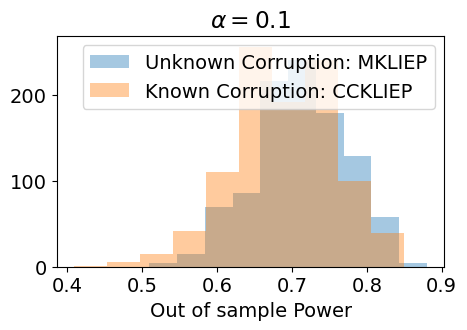

In [4]:
results_our = np.array(results["Learning Missingness Func"])[:,4,0]
results_naive = np.array(results["Naive"])[:,4,0]

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(results_our, alpha=0.4, label='Unknown Corruption: MKLIEP')
ax.hist(results_naive, alpha=0.4, label='Known Corruption: CCKLIEP')
ax.legend(loc='upper right')
ax.set(title=r"$\alpha=$"+str(params["alphas"][4]),xlabel="Out of sample Power")


plt.savefig("../plots/np_RWE_CTG_power_dist.pdf",bbox_inches="tight")

# Varying $\varphi$ to Vary Proportion Missing
We vary $a_{j,0}$ to vary the proportion of points missing. We now work out what $a_{j,0}$ ti choose to give our desired missing proportions

In [15]:
def miss_prop_opt(loc,data, m, std, sign, target_prop):
    varphi = create_standard_miss_func(m,std, sign,loc)
    return (torch.nanmean(varphi(data))-target_prop)**2


df_tens = torch.tensor(
    (df_fin_nodrop).to_numpy().astype(np.float32))

locs = []
miss_props = np.arange(0.1,1,0.1)
for miss_prop in miss_props:
    temp_locs = []
    for j in range(df_fin_nodrop.shape[1]):
        opt_plus = optimize.minimize_scalar(
            miss_prop_opt,args=(df_tens[:,j],m[j],std[j],1.,miss_prop))
        opt_minus = optimize.minimize_scalar(
            miss_prop_opt,args=(df_tens[:,j],m[j],std[j],-1.,miss_prop))
    
        temp_locs.append([opt_plus["x"], opt_minus["x"]])
    locs.append(temp_locs)

We now perform our procedure for these various missing proprtions

In [16]:
warnings.filterwarnings("ignore")
new_seed = 12345
reg = 0.
alphas = 0.1
deltas = 0.05
nsim = 1000
miss_props = np.arange(0.1,1,0.1)
mice_args = {"sample_posterior": False, "n_nearest_features": 9}  
true_meth = {
    key: [[] for j in range(miss_props.shape[0])]
    for key in ["power_res", "prop_miss", "true_prop_miss","grad"]
}

best_meth = deepcopy(true_meth)
naive_meth = deepcopy(true_meth)
mice_meth = deepcopy(true_meth)

for j, miss_prop in enumerate(miss_props):
    for i in range(nsim):
        torch.manual_seed(new_seed)
        # ### Seed Setting ### #
        split_seed = int(1e9*unif.sample([1])[0])
        miss_seed = int(1e9*unif.sample([1])[0])
        learn_seed = int(1e9*unif.sample([1])[0])
        new_seed = int(1e9*unif.sample([1])[0])

        # ### Chossing missing functions ### #
        signs = torch.tensor([-1., 1.])
        signs = signs[torch.multinomial(torch.zeros((2))+1,
         num_samples=df_fin_nodrop.shape[1],
                                        replacement=True)]

        sign_locs = ((signs+1)/2).int()
        missing_funcs = [create_standard_miss_func(
            m[l], std[l], -signs[l], shift=locs[j][l][sign_locs[l]])
            for l in range(df_fin_nodrop.shape[1])]

        # Test our method
        temp_our = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
            est_miss=True, alpha=alphas, delta=deltas, nlearn=10, maxiter=100,
            reg=reg, opt_type="scalar",lr=1, tol=1e-3,
            split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
        # Re-do with smaller LR if errors
        best_meth["power_res"][j].append(temp_our["power_res"][0])
        best_meth["prop_miss"][j].append(temp_our["prop_miss"])
        best_meth["true_prop_miss"][j].append(miss_prop)
        best_meth["grad"][j].append(temp_our["dr"]["gr"])

        # Test true method
        temp_true = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
            est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
            reg=reg, opt_type="scalar",lr=1, tol=1e-3,
            split_seed=split_seed, miss_seed=miss_seed)
        true_meth["power_res"][j].append(temp_true["power_res"][0])
        true_meth["prop_miss"][j].append(temp_true["prop_miss"])
        true_meth["true_prop_miss"][j].append(miss_prop)
        true_meth["grad"][j].append(temp_true["dr"]["gr"])

        # Test naive method
        temp_naive = full_pipeline(
            null_df, alt_df, missing_funcs, n_altte=100, n_nulltr=237,
            dr_proc=kliep_multi_dim_naive_sep_wrap,
            est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
            reg=reg, opt_type="scalar",lr=1, tol=1e-3,
            split_seed=split_seed, miss_seed=miss_seed)
        naive_meth["power_res"][j].append(temp_naive["power_res"][0])
        naive_meth["prop_miss"][j].append(temp_naive["prop_miss"])
        naive_meth["true_prop_miss"][j].append(miss_prop)
        naive_meth["grad"][j].append(temp_naive["dr"]["gr"])


        temp_mice = full_pipeline(
            null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
            dr_proc=kliep_multi_dim_sep_imp_wrap, impute="MICE", opt_type="Scalar",
            mice_args=mice_args, est_miss=False, lr=lr, alpha=alphas,
            delta=deltas, maxiter=1000,
            split_seed=split_seed, miss_seed=miss_seed)
        mice_meth["power_res"][j].append(temp_mice["power_res"][0])
        mice_meth["prop_miss"][j].append(temp_mice["prop_miss"])
        mice_meth["true_prop_miss"][j].append(miss_prop)
        mice_meth["grad"][j].append(temp_mice["dr"]["gr"])
        

        progress(int(100*(j*nsim+(i+1))/(nsim*miss_props.shape[0])))

results = {
    "Learning Missingness Func": best_meth,
    "Naive": naive_meth, "Known Missingness Func": true_meth,
    "Iterative Imputation": mice_meth
}

data = (results, {"alphas": alphas, "deltas": deltas})
with open('../results/real_world_results/CTG_fullrand_'+str(nsim)+'sim_allmeth_noreg_varymissfixed_scalar_test.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


[########################################]100%

Finally perform each procedure with no-missingness as a benchmark.

In [19]:
new_seed = 12345
reg = 0
alphas = 0.1
deltas = 0.05
nsim = 1000

lr = 0.7**(np.floor((np.arange(1000))/100)+1)

true_meth_0 = {
    key: [[]] for key in ["power_res", "prop_miss", "true_prop_miss","grad"]
}
best_meth_0 = deepcopy(true_meth_0)
naive_meth_0 = deepcopy(true_meth_0)
mice_meth_0 = deepcopy(true_meth_0)
miss_prop=0
for i in range(nsim):
    torch.manual_seed(new_seed)
    # ### Seed Setting ### #
    split_seed = int(1e9*unif.sample([1])[0])
    miss_seed = int(1e9*unif.sample([1])[0])
    learn_seed = int(1e9*unif.sample([1])[0])
    new_seed = int(1e9*unif.sample([1])[0])

    # ### Chossing missing functions ### #
    signs = torch.tensor([-1., 1.])
    signs = signs[torch.multinomial(torch.zeros((2))+1, num_samples=df_fin_nodrop.shape[1],
                                    replacement=True)]

    sign_locs = ((signs+1)/2).int()
    missing_funcs = [create_standard_miss_func(
        m[l], std[l], -signs[l], shift=locs[j][l][sign_locs[l]])
        for l in range(df_fin_nodrop.shape[1])]

    # Test our method
    temp_our = full_pipeline(
        null_df, alt_df, None, n_altte=100, n_nulltr=237,
        est_miss=False, alpha=alphas, delta=deltas, nlearn=10, maxiter=100,
        reg=reg, opt_type="scalar",lr=1, tol=1e-3,
        split_seed=split_seed, miss_seed=miss_seed, learn_seed=learn_seed)
    best_meth_0["power_res"][0].append(temp_our["power_res"][0])
    best_meth_0["prop_miss"][0].append(0)
    best_meth_0["true_prop_miss"][0].append(miss_prop)

    # Test true method
    temp_true = full_pipeline(
        null_df, alt_df, None, n_altte=100, n_nulltr=237,
        est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
        reg=reg, opt_type="scalar",lr=1, tol=1e-3,
        split_seed=split_seed, miss_seed=miss_seed)
    true_meth_0["power_res"][0].append(temp_true["power_res"][0])
    true_meth_0["prop_miss"][0].append(0)
    true_meth_0["true_prop_miss"][0].append(miss_prop)

    # Test naive method
    temp_naive = full_pipeline(
        null_df, alt_df, None, n_altte=100, n_nulltr=237,
        dr_proc=kliep_multi_dim_naive_sep_wrap,
        est_miss=False, alpha=alphas, delta=deltas, maxiter=100,
        reg=reg, opt_type="scalar",lr=1, tol=1e-3,
        split_seed=split_seed, miss_seed=miss_seed)
    naive_meth_0["power_res"][0].append(temp_naive["power_res"][0])
    naive_meth_0["prop_miss"][0].append(0)
    naive_meth_0["true_prop_miss"][0].append(miss_prop)

    temp_mice = full_pipeline(
            null_df, alt_df, missing_funcs=missing_funcs, n_altte=100, n_nulltr=237,
            impute=None, opt_type="Scalar",
            mice_args=mice_args, est_miss=False, lr=lr, alpha=alphas,
            delta=deltas, maxiter=1000,
            split_seed=split_seed, miss_seed=miss_seed)
    mice_meth_0["power_res"][0].append(temp_mice["power_res"][0])
    mice_meth_0["prop_miss"][0].append(temp_mice["prop_miss"])
    mice_meth_0["true_prop_miss"][0].append(miss_prop)
    mice_meth_0["grad"][0].append(temp_mice["dr"]["gr"])

    progress(int(100*(i+1)/nsim))

results = {
    "Learning Missingness Func": best_meth_0,
    "Naive": naive_meth_0, "Known Missingness Func": true_meth_0, 
    "Iterative Imputation": mice_meth_0
}

data = (results, {"alphas": alphas, "deltas": deltas})
with open('../results/real_world_results/CTG_fullrand_'+str(nsim)+'sim_allmeth_nomiss_scalar_test.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


[########################################]100%

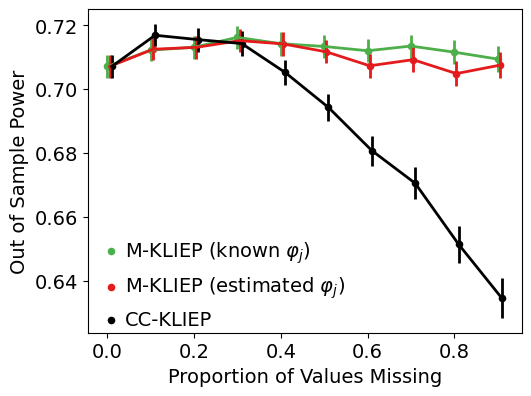

In [5]:
with open('../results/real_world_results/CTG_fullrand_1000sim_allmeth_nomiss_scalar_test.pkl', 'rb') as handle:
    no_miss_results, params = pickle.load(handle)

with open('../results/real_world_results/CTG_fullrand_1000sim_allmeth_noreg_varymissfixed_scalar_test.pkl', 'rb') as handle:
    results, params = pickle.load(handle)

names = {
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$) ",
    "Naive": "CC-KLIEP",
}


cs=[u'#377eb8',u'#4daf4a', u'#e41a1c',u'#000000', u"#984ea3"]
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(names):
    x = torch.mean(torch.tensor(no_miss_results[key]["true_prop_miss"]+results[key]["true_prop_miss"]),dim=1)
    all_cis = get_ci(torch.tensor(no_miss_results[key]["power_res"]+results[key]["power_res"])[:, :, 0].T,
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff = x[1]-x[0]

    x_jit = x+diff*0.05*i
    ax.scatter(x_jit, y, label=names[key], s=20,c=cs[i+1])
    ax.errorbar(x_jit, y, error,c=cs[i+1], linewidth=2)

ax.set(xlabel="Proportion of Values Missing", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)


plt.savefig("../plots/np_RWE_CTG_varymissfixed.pdf",
            bbox_inches="tight", dpi=300)

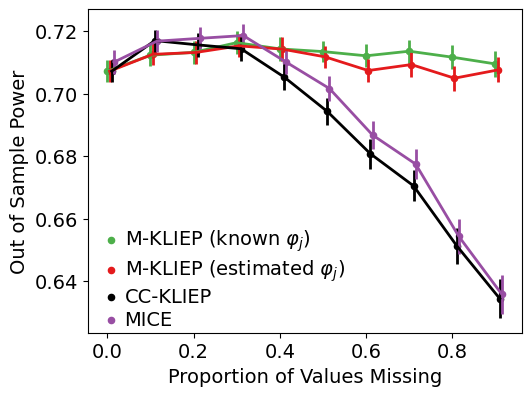

In [6]:
with open('../results/real_world_results/CTG_fullrand_1000sim_allmeth_nomiss_scalar_test.pkl', 'rb') as handle:
    no_miss_results, params = pickle.load(handle)

with open('../results/real_world_results/CTG_fullrand_1000sim_allmeth_noreg_varymissfixed_scalar_test.pkl', 'rb') as handle:
    results, params = pickle.load(handle)

names = {
    "Known Missingness Func": r"M-KLIEP (known $\varphi_j$)",
    "Learning Missingness Func": r"M-KLIEP (estimated $\varphi_j$) ",
    "Naive": "CC-KLIEP",
    "Iterative Imputation": "MICE"
}


cs=[u'#377eb8',u'#4daf4a', u'#e41a1c',u'#000000', u"#984ea3"]
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(names):
    x = torch.mean(torch.tensor(no_miss_results[key]["true_prop_miss"]+results[key]["true_prop_miss"]),dim=1)
    all_cis = get_ci(torch.tensor(no_miss_results[key]["power_res"]+results[key]["power_res"])[:, :, 0].T,
                     verbose=False)

    y1 = all_cis[1]
    y2 = all_cis[2]
    y = all_cis[0]
    error = y2-y

    diff = x[1]-x[0]

    x_jit = x+diff*0.05*i
    ax.scatter(x_jit, y, label=names[key], s=20,c=cs[i+1])
    ax.errorbar(x_jit, y, error,c=cs[i+1], linewidth=2)

ax.set(xlabel="Proportion of Values Missing", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False, labelspacing=0.2)


plt.savefig("../plots/np_RWE_CTG_varymissfixed_mice.pdf",
            bbox_inches="tight", dpi=300)